# [Hands On] Fine Tuning Mistral 7b on single free Colab GPU

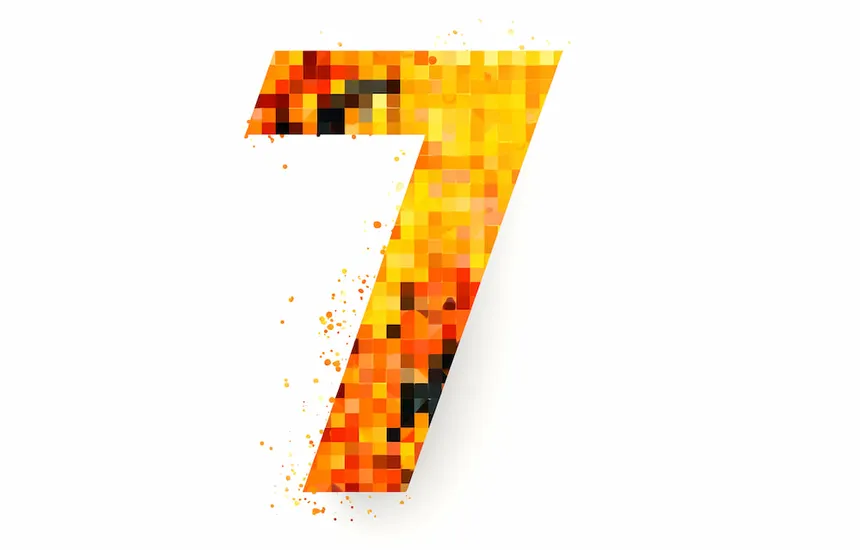

## 🎨 Summary

### I - Boilerplates 👷


### II - Business Dataset Preparation 📝


### III - Model Loading (Quantized params) 🧪


### IV - Lora Module 💥


### V - Train the model 🦾


### VI - Check the results 🎉


## 👷 Boilerplates / Import .. 👷

### Install needed packages

Just run the cells below

In [ ]:
!python --version

Python 3.10.12


In [ ]:
%pip install --upgrade pip --quiet
%pip install --disable-pip-version-check \
    torch \
    torchdata==0.5.1 --quiet

%pip install -q -U trl==0.7.11 --quiet
%pip install -q -U peft --quiet
%pip install -q -U transformers==4.37.2 --quiet

%pip install \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    sentencepiece==0.1.99 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    accelerate==0.21.0 --quiet

%pip install bitsandbytes==0.41.3.post2 --quiet

In [10]:
%pip freeze | grep sentencepiece

sentencepiece==0.1.99


### GPU available ?

Double check we are on **GPU**

In [9]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [11]:
# Output the GPU name, device etc..
!nvidia-smi

Wed Feb 28 17:50:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

torch.version.cuda

'11.7'

In [14]:
!python -m bitsandbytes | grep False

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/usr/local/lib/python3.10/dist-packages/bitsandbytes/__init__.py", line 6, in <module>
    from . import cuda_setup, utils, research
  File "/usr/local/lib/python3.10/dist-packag

## Cuda version mismatch

If torch CUDA version does not match System CUDA version AND `!python -m bitsandbytes` display an error.

Go to the [cuda archive link](https://developer.nvidia.com/cuda-toolkit-archive) and follow the steps from [this post](https://stackoverflow.com/a/74561909) in order to install the cuda version that match the version specified by `torch.version.cuda`.


Initial issue can be found here on [bitsandbytes](https://github.com/TimDettmers/bitsandbytes/issues/931)


!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!dpkg -i cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!cp /var/cuda-repo-ubuntu2204-11-7-local/cuda-*-keyring.gpg /usr/share/keyrings/
!apt-get update
!apt-get -y install cuda-11-7

In [ ]:
%%capture
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!dpkg -i cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!cp /var/cuda-repo-ubuntu2204-11-7-local/cuda-*-keyring.gpg /usr/share/keyrings/
!apt-get update
!apt-get -y install cuda-11-7

In [ ]:
# Now the following command should output SUCCESS

!python -m bitsandbytes | grep SUCCESS

SUCCESS!


In [ ]:
%pip show bitsandbytes

Name: bitsandbytes
Version: 0.41.3.post2
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


### General Import

In [ ]:
from typing import List, Dict, Optional, Union, Any

## 📝 Dataset preparation 📝

For our experiment, we will use the Zelros Insurance dataset in French, which is small density high quality dataset used to answer questions related to insurance.

The dataset can be found [here](https://huggingface.co/datasets/zelros/insurance-fr).
If you need another dataset, Huggingface provides some other ressources like [awesome-sft-dataset](https://huggingface.co/collections/HuggingFaceH4/awesome-sft-datasets-65788b571bf8e371c4e4241a).


Some transformation will be done on dataset to ensure we follow good guidelines to fine tune a model.
Transformations include :


*   🗣️ Ensuring the preprompt gives context related to insurance
*   💬 prepare instruction and response template



In [ ]:
import datasets
from datasets import load_dataset

dataset_name: str = "zelros/insurance-fr"

################################################################################
# Data set loading
################################################################################
dataset_raw: datasets.arrow_dataset.Dataset = (
    load_dataset(
        dataset_name,
        split="train"
    )
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/zelros___csv/zelros--insurance-fr-8ff53c58d6bb9084/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


In [ ]:
print(type(dataset_raw))
dataset_raw[0]

<class 'datasets.arrow_dataset.Dataset'>


{'title': "Qu'est-ce que l'assurance responsabilité civile des enfants",
 'content': 'L’assurance responsabilité civile des enfants permet de prendre en charge les dommages corporels et matériels que votre enfant cause à un tiers. Généralement incluse dans votre assurance habitation, cette garantie est également couverte par l’assurance scolaire. Quelle solution choisir pour couvrir au mieux vos enfants ?'}

We need to convert the dialog-answer (prompt 'title' - response 'content') pairs into explicit instructions for the LLM. we pretend an instruction to the start of the dialog with `Question Réponse entre un client et un expert en assurance.`

In [ ]:
################################################################################
# prompt template
################################################################################

# `pre_prompt` gives the context related to insurance.
pre_prompt: str = (
    "Question Réponse entre un client et un expert en assurance."
)

# `question_template` introduces the user question.
question_template: str = "### Question du client:"

# `instruction_template` mixes pre_promt AND question template
instruction_template: str = pre_prompt + question_template

# `response_template` introduces the assistant answer.
response_template: str = "### Réponse de l'expert en assurance:"


In [ ]:
################################################################################
# utils functions
################################################################################

def promptize_input(
    data: Dict[str, str],
    add_answer: bool = False
  ) -> str:
  """
  Allows to generate prompt with context preprompt, question and optional answer.

  Parameters
  ----------
  data: Dict[str, str]
  add_answer: bool, by default False
    If `add_answer`, add the correct output of the dataset.


  Returns
  -------
  str
  """
  human: str = (
      f"{instruction_template}\n {data['title']}\n"
  )
  final_prompt = human

  if add_answer:
    assistant: str = f"{response_template}\n {data['content']}"
    final_prompt += assistant

  return final_prompt


In [ ]:
################################################################################
# dataset transformation
################################################################################
new_column: List[str] = []

for _, data in enumerate(dataset_raw):
  new_column.append(
      promptize_input(data=data, add_answer=True)
  )

print(new_column[45])

# adding new column (to remove use `dataset.remove_columns(["text"])`)
dataset = (
    dataset_raw.add_column(
        "text",
        new_column
    )
)

# split the dataset in train and test
dataset = dataset.train_test_split(test_size=0.1, seed=42)

Question Réponse entre un client et un expert en assurance.### Question du client:
 L’assurance locative est-elle obligatoire ?
### Réponse de l'expert en assurance:
 Si vous êtes locataire d’un logement, que ce soit un appartement, une maison ou un studio, la loi du 6 juillet 1989 vous oblige à souscrire une assurance habitation auprès de l’assureur de votre choix. Mais seule la garantie « risques locatifs » est obligatoire.
 
A noter : votre propriétaire est en droit d’exiger une attestation d’assurance habitation :

- lors de la signature du bail de location,
- chaque année à la date anniversaire de la signature du bail.

En l’absence de ce justificatif, le bailleur peut renoncer à signer le bail ou le résilier de plein droit.


/usr/local/lib/python3.10/dist-packages/datasets/table.py:1373: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [ ]:
print(type(dataset["train"]))
dataset

<class 'datasets.arrow_dataset.Dataset'>


DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'text'],
        num_rows: 180
    })
    test: Dataset({
        features: ['title', 'content', 'text'],
        num_rows: 21
    })
})

In [ ]:
################################################################################
# compare original dataset vs transformed dataset
################################################################################
import random

random_idx: int = random.randint(0, len(dataset["train"]) - 1)

# Initial dataset
print("=" * 50 + "  INITIAL DATASET  " + "="*50 + "\n\n")
print(dataset["train"][random_idx]["title"])
print(dataset["train"][random_idx]["content"])


# refined dataset
print("\n\n" + "=" * 50 + "  REFINED DATASET  " + "="*50 + "\n\n")
print(dataset["train"][random_idx]["text"])

==================================================  INITIAL DATASET  ==================================================


On a volé des objets à risque de vol dans une dépendance de mon habitation principale, suis-je couvert ?
Les objets à risque de vol (voir définition) situés dans les dépendances et locaux attenants sans communication directe avec l’habitation principale ne sont pas assurés


==================================================  REFINED DATASET  ==================================================


Question Réponse entre un client et un expert en assurance.### Question du client:
 On a volé des objets à risque de vol dans une dépendance de mon habitation principale, suis-je couvert ?
### Réponse de l'expert en assurance:
 Les objets à risque de vol (voir définition) situés dans les dépendances et locaux attenants sans communication directe avec l’habitation principale ne sont pas assurés


In [ ]:
dataset.save_to_disk("dataset")

Saving the dataset (0/1 shards):   0%|          | 0/180 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21 [00:00<?, ? examples/s]

##  🧪 Models (and needed *layers*) + Tokenizer 🧪

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer
)
from trl import DataCollatorForCompletionOnlyLM

### Bits and Bytes loading



#### **Floating precision**


Quick reminder about difference in **Normal** vs **Brain** Float.

As explained in this [huggingface chat](https://huggingface.co/PygmalionAI/pygmalion-7b/discussions/3#644f684428774bd665cea8f5):


*Standard 16-bit floats weren't really designed for AI, they have better precision than bfloats (which is better for most use-cases), but also store a smaller range than 32-bit floats do (which affects prediction quality). It's also much easier to convert from 32-bit float to 16-bit bfloat since you only have to truncate the mantissa bits down to 16-bit.*


Bfloat improves stability during training as well, compared to half-precision (fp16) format.

For example, the (mistral 7b)[https://huggingface.co/mistralai/Mistral-7B-v0.1] is bf16 precision.
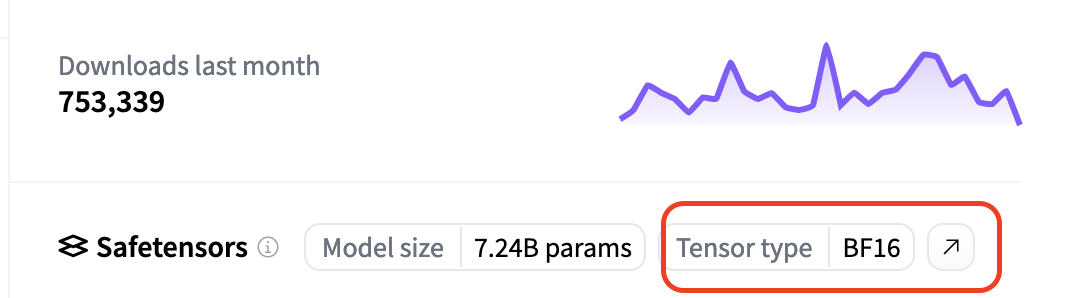
#### **Impact on size of model**

Typically, one performs "full fine-tuning": this means that we will simply update all the weights of the base model during fine-tuning. This is then typically done either in full precision (float32), or mixed precision (a combination of float32 and float16). However, with ever larger models like LLMs, this becomes infeasible.

For reference, float32 means that each parameter of a model gets saved in 32 bits or 4 bytes. Hence, for a 7 billion parameter model like Mistral-7B, one requires 7 billion parameters * 4 bytes per parameter = 28 GB of GPU RAM, just to load the model. During training with an optimizer like AdamW, one not only requires memory for the model but also for the gradients and optimizer states, which roughly comes down to approximately 18 times the size of the model in gigabytes when training with mixed precision, in this case 7 * 18 = 126 GB of GPU RAM. And that's just for a 7B parameter model! See the guide for more info: https://huggingface.co/docs/transformers/v4.20.1/en/perf_train_gpu_one.


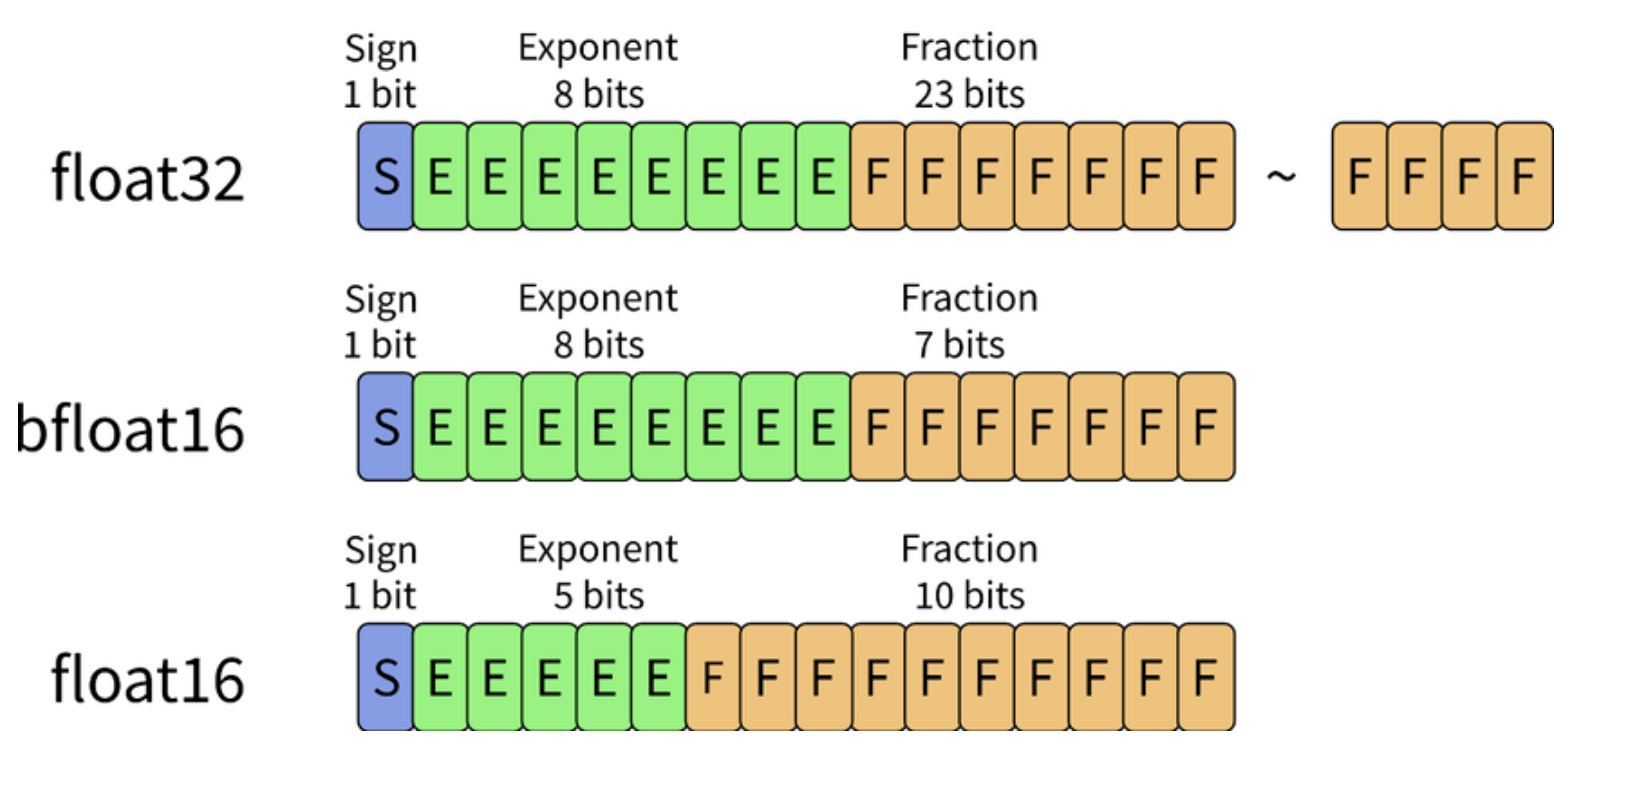

### Quantization explained in a graph

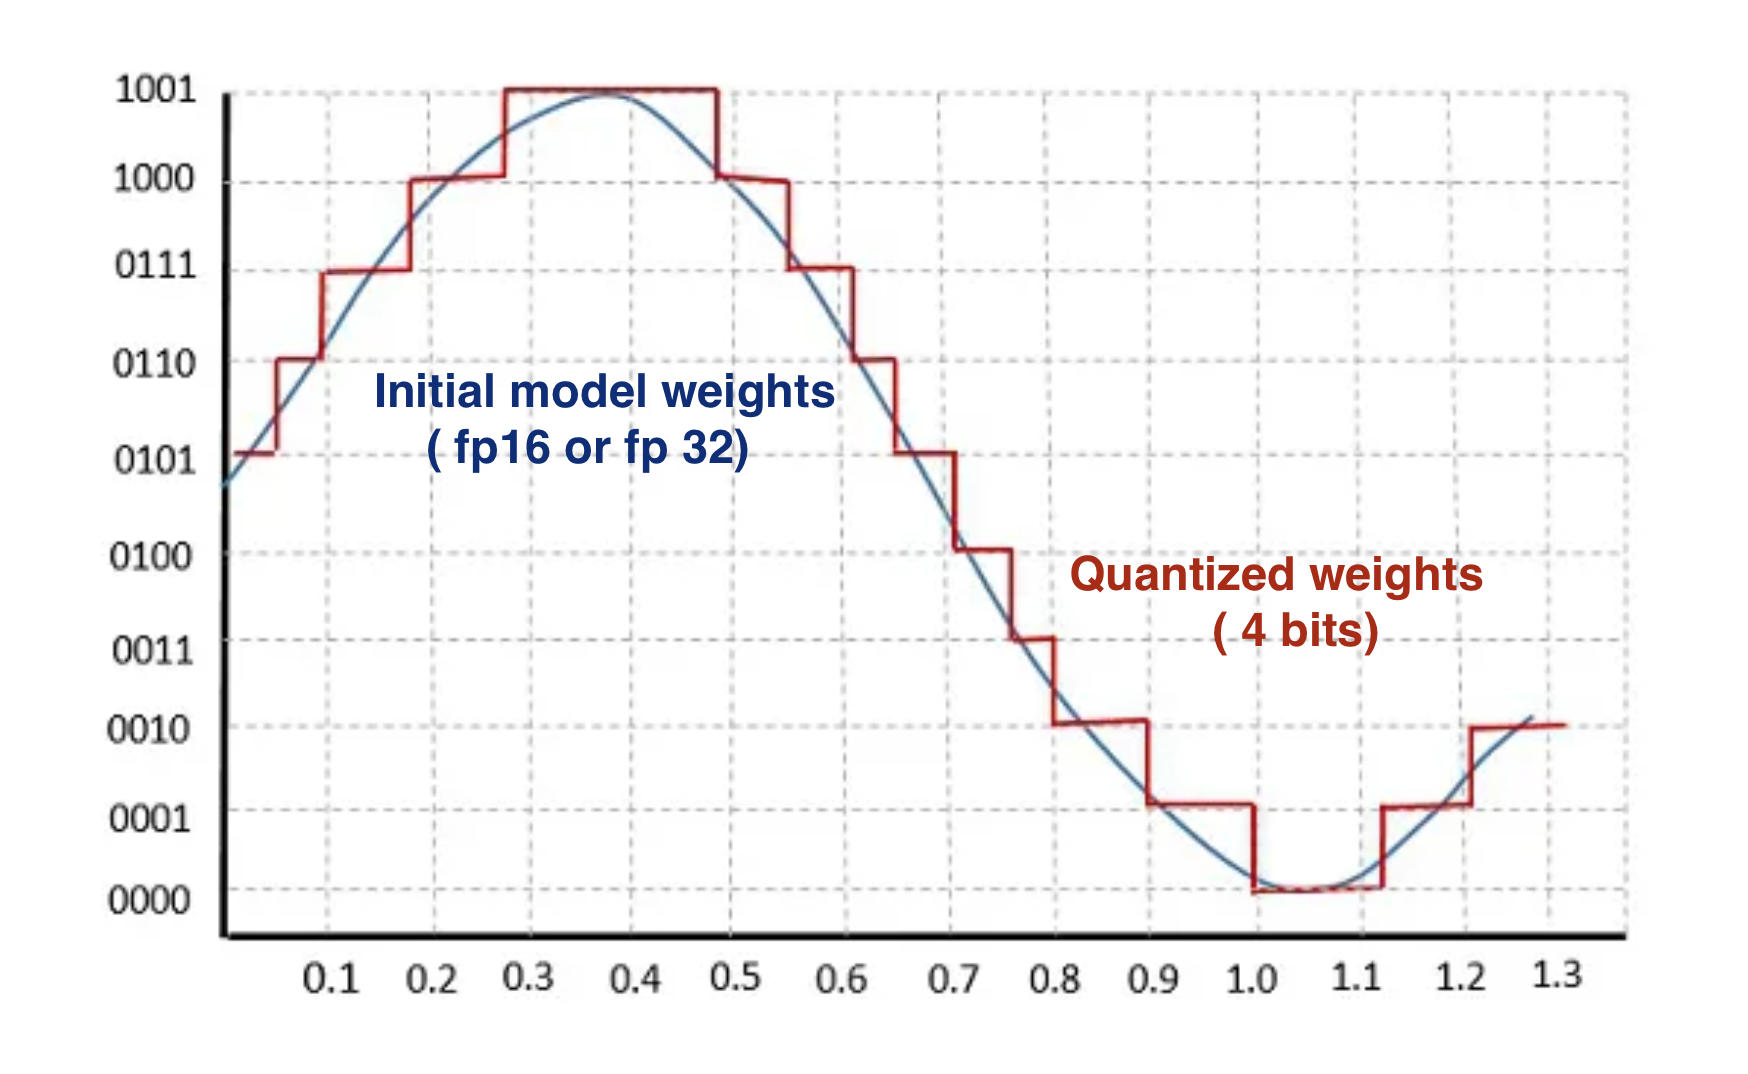

In [ ]:
################################################################################
# bitsandbytes parameters
################################################################################

# More information here :
# https://huggingface.co/docs/transformers/main_classes/quantization

# Activate 4-bit precision base model loading
load_in_4bit: bool = True

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type: str = "nf4"

# Compute dtype for 4-bit base models
compute_dtype: str = "float16"
bnb_4bit_compute_dtype = getattr(torch, compute_dtype)
assert bnb_4bit_compute_dtype == torch.float16

# Activate nested quantization for 4-bit base models (double quantization)
bnb_4bit_use_double_quant = False

################################################################################
# bitsandbytes loading
################################################################################
bnb_config = BitsAndBytesConfig(
    load_in_4bit=load_in_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=torch.float16, # Optimizer states remains in f32
    bnb_4bit_use_double_quant=bnb_4bit_use_double_quant,
)

### Mistral 7b Model loading

In [ ]:
################################################################################
# model parameters
################################################################################

# Model name to find on HuggingFace.
# Here we take a sharded model so it fits on single GPU during loading
model_name: str = (
  "ybelkada/Mistral-7B-v0.1-bf16-sharded"
)
# Load the entire model on the GPU 0
# Please note that device_map=auto should be used for inference only.
device_map: Dict[str, int] = {
    "": 0
}

################################################################################
# model raw loading
################################################################################
model_raw = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)
model_raw.config.use_cache = False

# Necessary to ensure exact reproducibility of the pretraining results.
model_raw.config.pretraining_tp = 1

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
print("="*180)
print("Printing the model (with `print(model)` is needed to indentify the `target_modules` in LoraConfig")
print("="*180)

#print(model)

Printing the model (with `print(model)` is needed to indentify the `target_modules` in LoraConfig


### Tokenizer loading

In [ ]:
################################################################################
# tokenizer loading
################################################################################
model_name: str = (
  "ybelkada/Mistral-7B-v0.1-bf16-sharded"
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    # trust_remote_code=True
)

# padding
# by default the tokenizer does not have token id,
# because during pretraining, no need to pad.
# for SFT, as we train in batch with text of different lenght, we need a pad token
tokenizer.pad_token = tokenizer.eos_token # tokenizer.add_special_tokens({"pad_token": "<pad>"})

# fix weird overflow issue with fp16 training
tokenizer.padding_side = "right"

# max length of tokenizer ?
print(f"tokenizer (initial) max lenght is {tokenizer.model_max_length}")
if tokenizer.model_max_length > 100_000:
  tokenizer.model_max_length: int = 2048
print(f"tokenizer (updated) max lenght is {tokenizer.model_max_length}")

# which tokenizer is used by Mistral ?
print(f"tokenizer inherits from {tokenizer.__class__.__name__}")

tokenizer (initial) max lenght is 1000000000000000019884624838656
tokenizer (updated) max lenght is 2048
tokenizer inherits from LlamaTokenizerFast


## 💥 Load the Lora module *💥*

Below we will load the configuration file in order to create the LoRA model. According to QLoRA paper, it is important to consider all linear layers in the transformer block for maximum performance. Therefore we will add `gate_proj`, `up_proj` and `down_proj` layers in the target modules in addition to the mixed query key value layer.

LoRAs are residual layers that add A B * scaling to the original output, where A and B are low rank matrices and scaling is a constant given by alpha / rank. The weight initialization is independent of alpha.


*source: https://www.youtube.com/watch?v=dA-NhCtrrVE&t=196s*

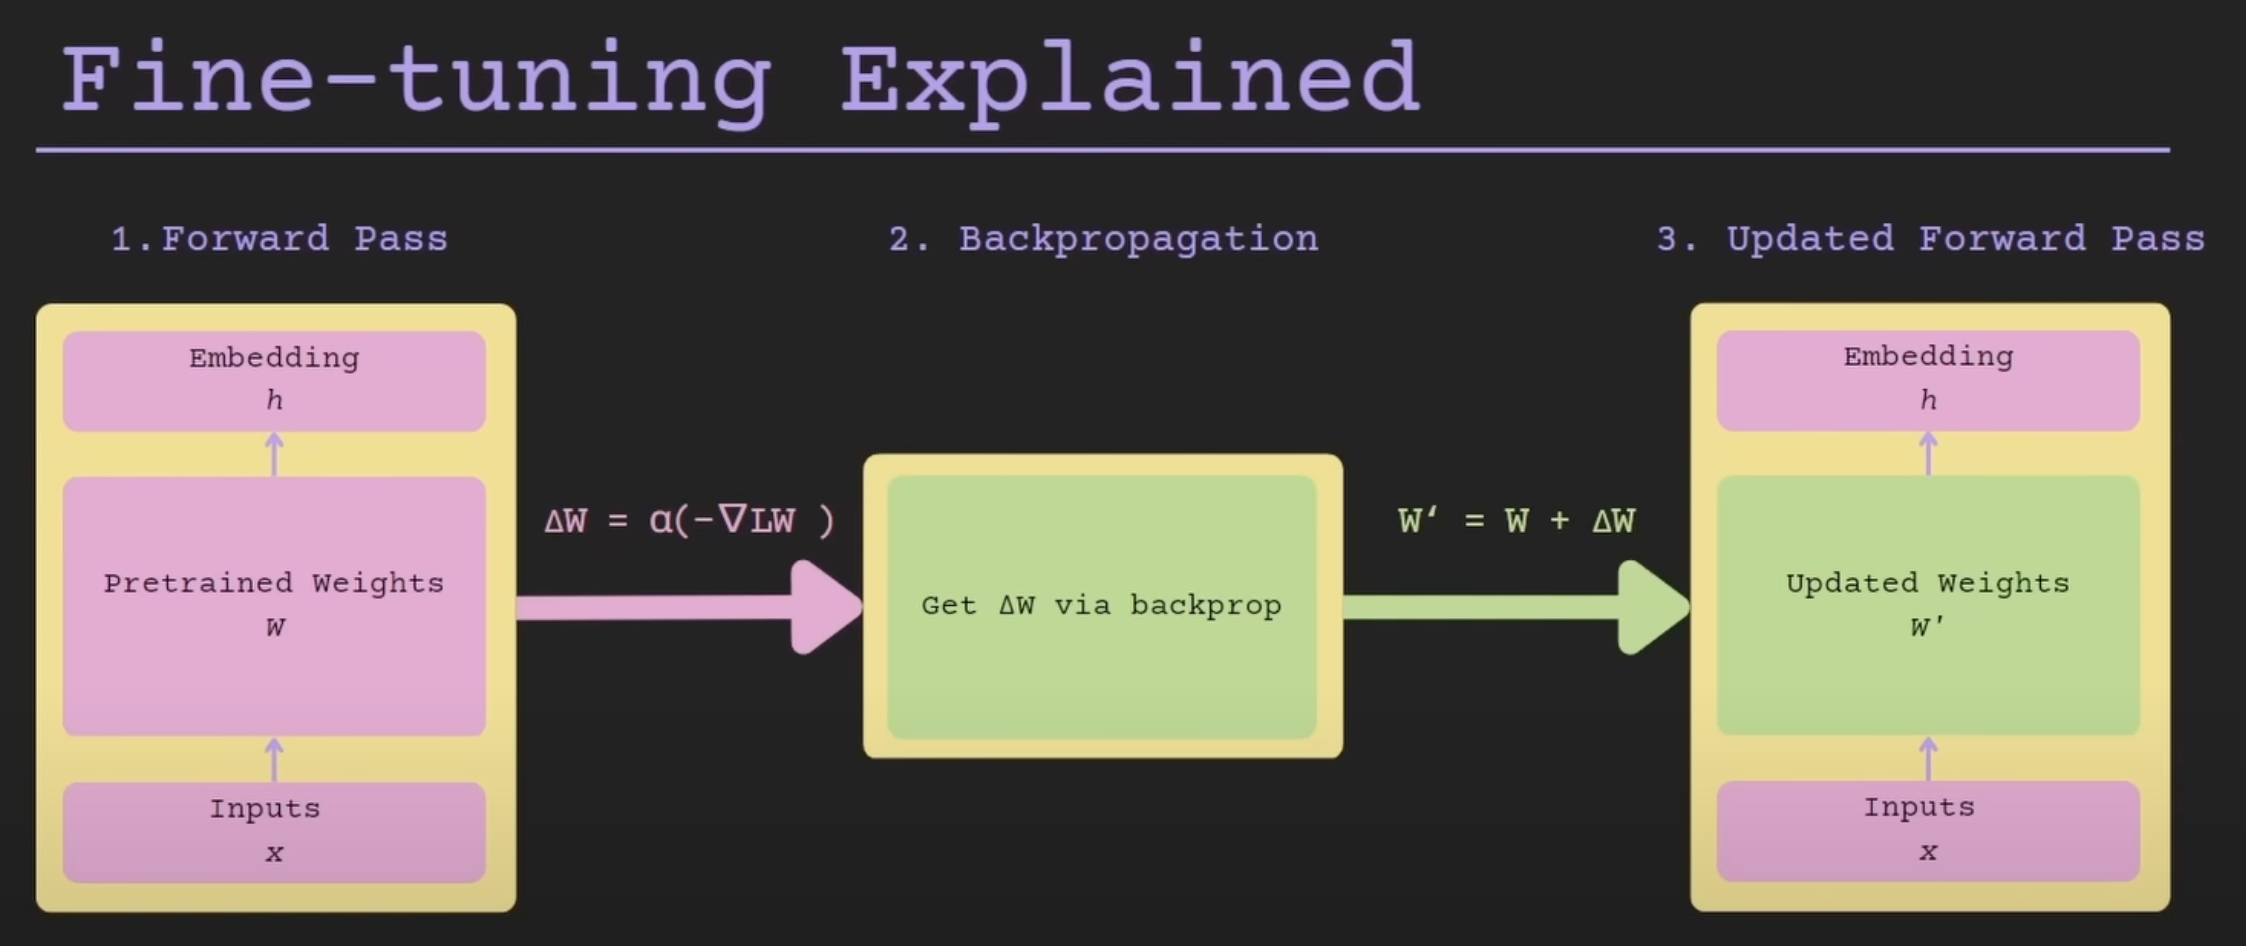

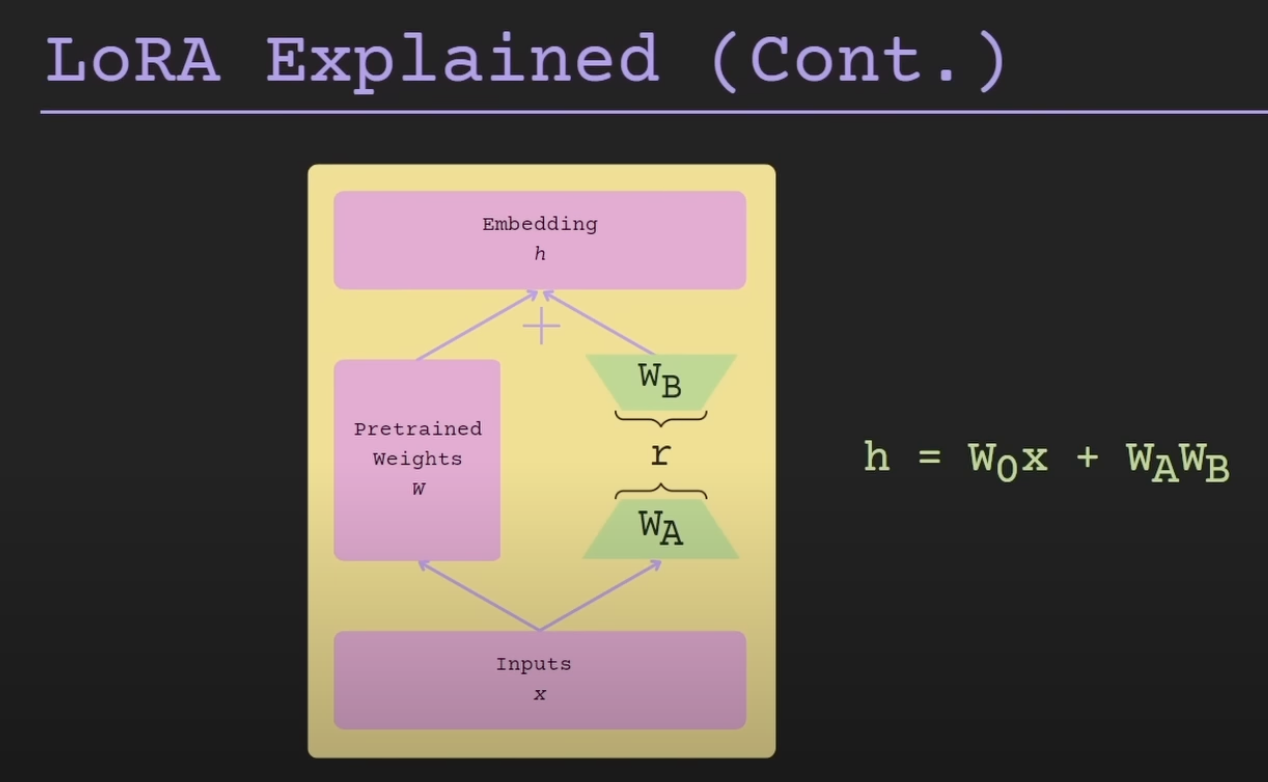

In [12]:
from IPython.display import Image
Image(url="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/blog/133_trl_peft/lora-animated.gif")


### Rank reduction on a visual matrix (i.e a picture) 📸

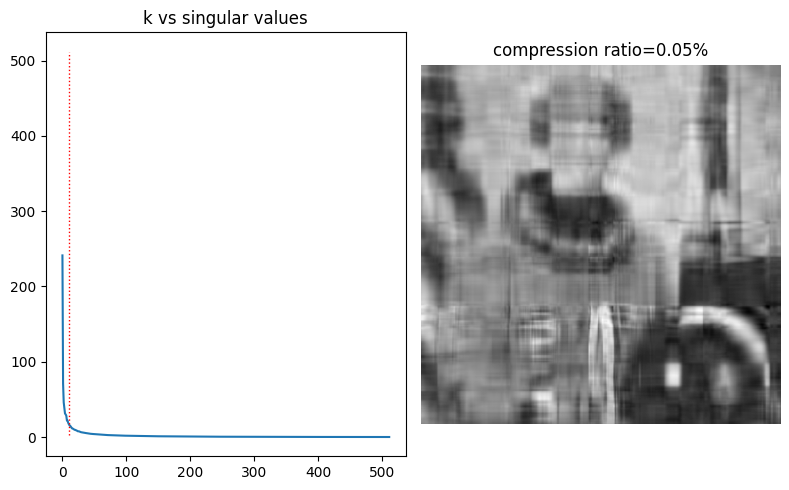

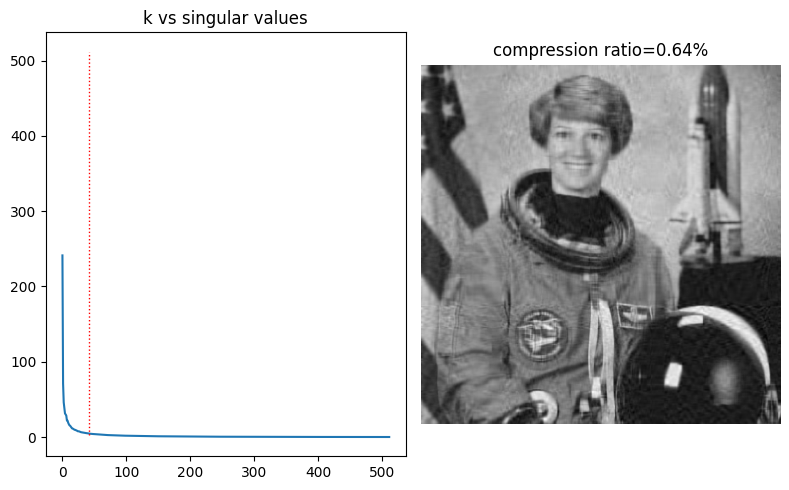

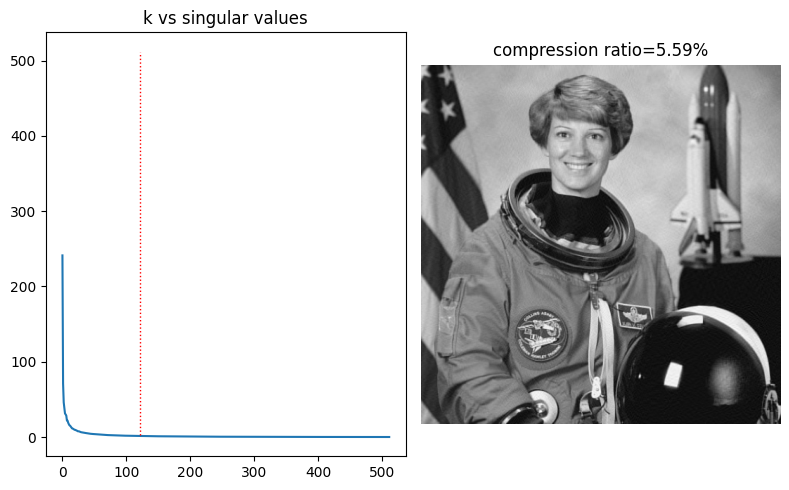

In [1]:
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training
)

ModuleNotFoundError: No module named 'peft'

In [ ]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension, rank to reduce the matrix
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

# module to apply rank reduction on
target_modules: List[str] = [
    "q_proj", # self attention query
    "k_proj", # self attention key
    "v_proj", # self attention value
    "o_proj", # self attention value
    "gate_proj", # feed forward after attention
    "up_proj", # feed forward after attention
    "down_proj", # feed forward after attention
] # https://github.com/huggingface/transformers/blob/f9f1f2ac5e03bba46d18cfc5df30472b2b85ba54/src/transformers/models/mistral/modeling_mistral.py#L193C7-L193C23

# Causal language modeling, not 'masked' as it is decoder
task_type: str = "CAUSAL_LM"

################################################################################
# Lora loading
################################################################################

peft_config = LoraConfig(
    lora_alpha=lora_alpha,  # Scaling the weight
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type=task_type,
    target_modules=target_modules
)

In [ ]:
################################################################################
# Lora see numbers of trainable params
################################################################################
from peft import get_peft_model

model = get_peft_model(model_raw, peft_config)
model.print_trainable_parameters()

trainable params: 167,772,160 || all params: 7,409,504,256 || trainable%: 2.264283199029719


168 millions * 4 bytes (i.e 32 bits) ~= 672 millions bytes ~= 0.67 gB * 18 (18 is for optimizer states) = 12 gB

7.4 billions * 0.5 bytes (i.e 4 bits with BitsAndBytesConfig) ~= 3.7 billions bytes ~= 3.7 gB

If we cumulate, that should do the math below 16gB

## 🦾 Loading the trainer 🦾
Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

In [ ]:
################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir: str = "./results"

# Number of training epochs
num_train_epochs: int = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16: bool = True
bf16: bool = False

# Check GPU compatibility with bfloat16 compute
if bnb_4bit_compute_dtype == torch.float16 and load_in_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)
        fp16: bool = False
        bf16: bool = True

# Batch size per GPU for training
per_device_train_batch_size: int = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size: int = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps: int = 4

# Maximum gradient normal (gradient clipping)
max_grad_norm: float = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate: float = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay: float = 0.001

# Optimizer to use
optim: str = "paged_adamw_32bit"

# Learning rate schedule 'cosine' or 'constant'
lr_scheduler_type: str = "cosine"

# Number of training steps (overrides num_train_epochs if > 0)
max_steps: int = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio: float = 0.03

# Group sequences into batches with roughly the same length
# Saves memory by miminizing padding and speeds up training considerably
# Only useful if applying dynamic padding.
group_by_length: Optional[bool] = False

# Save checkpoint every X updates steps
save_steps: int = 5

# Log every X updates steps
logging_steps: int = 5

# Gradient checkpointing is a technique in deep learning
# that selectively stores checkpoints during the backpropagation process,
# reducing memory consumption by avoiding the need to store all intermediate states.
gradient_checkpointing: bool = True

# show loss at each step / epoch
evaluation_strategy: str = "steps"


### Loading the DataCollatorForCompletionOnlyLM

In [ ]:
from trl import DataCollatorForCompletionOnlyLM

def formatting_prompts_func(
    dataset_input: datasets.arrow_dataset.Dataset
  ) -> List[str]:
  """
  Iterating through dataset: adding prompt and contatening input and output

  Parameters
  ----------
  dataset_input: datasets.arrow_dataset.Dataset

  Returns
  -------
  List[str]

  """
  output_texts: List[str] = []

  for i in range(len(dataset_input["title"])):
      text: str = (
          f"{instruction_template}\n {dataset_input['title'][i]}\n"
          f"{response_template}\n {dataset_input['content'][i]}"
      )
      output_texts.append(text)
  return output_texts

# Prompt template
# `pre_prompt` gives the context related to insurance.
pre_prompt: str = (
    "Question Réponse entre un client et un expert en assurance."
)

# `question_template` introduces the user question.
question_template: str = "### Question du client:"

# `instruction_template` mixes pre_promt AND question template
instruction_template: str = pre_prompt + question_template

# `response_template` introduces the assistant answer.
response_template: str = "### Réponse de l'expert en assurance:"
response_template_with_context = f"\n{response_template}"  # We added context here: "\n". This is enough for this tokenizer
response_template_ids_context_trunc = tokenizer.encode(response_template_with_context, add_special_tokens=False)[2:]  # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]`

# Input parameters
collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template_ids_context_trunc,
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
################################################################################
# TrainingArguments loading
################################################################################

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=gradient_checkpointing,
    # report_to="tensorboard"
)

In [ ]:
################################################################################
# SFT Trainer parameters
################################################################################

# train test eval
dataset_text_field: str = "text"
dataset_train_key: str = "train"
dataset_eval_key: str = "test"

# Maximum sequence length to use
max_seq_length: Optional[int] = 512

# SFTTrainer supports example packing,
# where multiple short examples are packed in the same input sequence,
# to increase training efficiency, not compatible with datacollator
packing: bool = False

# Load the entire model on the GPU 0
device_map: Dict[str, int] = {"": 0}


In [ ]:
type(dataset["train"])


datasets.arrow_dataset.Dataset

In [ ]:
################################################################################
# SFT Trainer Loading
################################################################################

# Init the trainer
trainer = SFTTrainer(
    model=model_raw,
    train_dataset=dataset[dataset_train_key],
    # eval_dataset=dataset[dataset_eval_key],
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    # dataset_text_field=dataset_text_field,
    data_collator=collator,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing
)


Map:   0%|          | 0/180 [00:00<?, ? examples/s]

We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
# Cast the layernorm in fp32, make output embedding layer require grads,
# add the upcasting of the lmhead to fp32
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

# model_raw = prepare_model_for_kbit_training(model_raw)

## 🦾 Train the model 🦾

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Now let's train the model! Simply call `trainer.train()`

More information here :
https://huggingface.co/docs/trl/sft_trainer

In [ ]:
trainer.train()

Step,Training Loss
5,1.499700
10,1.366600
15,1.211500
20,1.068500
25,0.963100
30,0.889700


TrainOutput(global_step=33, training_loss=1.1469327608744304, metrics={'train_runtime': 919.3119, 'train_samples_per_second': 0.587, 'train_steps_per_second': 0.036, 'total_flos': 8663372345671680.0, 'train_loss': 1.1469327608744304, 'epoch': 2.93})

In [ ]:
model_adapter: str = "mistral-2-7b-ft"

################################################################################
# Model Trained Saving
################################################################################

#model_upd = trainer.model
#model_upd.save_pretrained(new_model)
#tokenizer.save_pretrained(new_model)
trainer.save_model(model_adapter)

In [ ]:
# Empty VRAM
del model
del trainer
del tokenizer
import gc
gc.collect()
torch.cuda.empty_cache()

# !!! RESTART THE SESSION !!! and load adapters


## 🎉 Test the model 🎉

In [ ]:
from typing import List, Dict, Optional, Union, Any
from datasets import Dataset, DatasetDict
import torch
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
from peft import PeftConfig, PeftModel

In [ ]:
model_adapter: str = "mistral-2-7b-ft"

peft_config = PeftConfig.from_pretrained(model_adapter)

bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.float16,
  bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = (
    AutoTokenizer.from_pretrained(
        peft_config.base_model_name_or_path
    )
)

model = PeftModel.from_pretrained(model, model_adapter)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
dataset = DatasetDict.load_from_disk("dataset")

In [ ]:
index = 6 # max is 21

################################################################################
# prepare prompt
################################################################################
answer = dataset["test"][index]["content"]
prompt = promptize_input(
    data=dataset["test"][index],
    add_answer=False
)
instruction = prompt + response_template
print(instruction)

Question Réponse entre un client et un expert en assurance.### Question du client:
 Que faire en cas de dommage électrique ?
### Réponse de l'expert en assurance:


In [ ]:
def generate(instruction: str, adapter: bool):
  # ensuring device is GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("device is : ", device)

  # tokenizer + mapping to GPU
  inputs = tokenizer(instruction, return_tensors="pt").to(device)

  if adapter:
    # merge adapter to have new model fined tuned
    model.merge_adapter()
  else:
    # unmerge adapter to have the base model
    model.unmerge_adapter()

  # generation of text
  output = tokenizer.decode(
      model.generate(
          inputs["input_ids"],
          pad_token_id=tokenizer.pad_token_id, # avoids warning
          max_new_tokens=512,
      )[0],
      skip_special_tokens=True
  )

  # display output
  dash_line = '-'.join('' for x in range(100))
  print(dash_line)
  print(f'INPUT PROMPT:\n{prompt}')
  print(dash_line)
  print(f'BASELINE HUMAN SUMMARY:\n{answer}\n')
  print(dash_line)
  if adapter:
    print(f'FINED TUNED MODEL GENERATION:\n{output}')
  else:
    print(f'BASE MODEL GENERATION:\n{output}')

In [ ]:
################################################################################
# [OLD MODEL] generate the output [OLD MODEL]
################################################################################
generate(instruction=instruction, adapter=False)

device is :  cuda


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:281: UserWarning: Unmerge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 Que faire en cas de dommage électrique ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
- Vérifiez le bon fonctionnement de tous les appareils électriques reliés au secteur au moment du sinistre, répertoriez ceux qui ont subi des dommages.
- Réunissez tous les éléments susceptibles de prouver leur valeur : factures, certificats de garantie ou encore dossiers de crédit.
- Prévenez votre assureur et déclarez le sinistre dans les cinq jours ouvrés.
- N’engagez aucune réparation avant d’avoir obtenu l’accord de votre assurance.

---------------------------------------------------------------------------------------------------
BASE MODEL GENERATION:
Question Réponse entre un client et un expert en assurance.### Questio

In [ ]:
################################################################################
# [NEW MODEL] generate the output [NEW MODEL]
################################################################################
generate(instruction=instruction, adapter=True)

device is :  cuda
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 Que faire en cas de dommage électrique ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
- Vérifiez le bon fonctionnement de tous les appareils électriques reliés au secteur au moment du sinistre, répertoriez ceux qui ont subi des dommages.
- Réunissez tous les éléments susceptibles de prouver leur valeur : factures, certificats de garantie ou encore dossiers de crédit.
- Prévenez votre assureur et déclarez le sinistre dans les cinq jours ouvrés.
- N’engagez aucune réparation avant d’avoir obtenu l’accord de votre assurance.

---------------------------------------------------------------------------------------------------
FINED TUNED MODEL GENERATION:
Question Réponse entre un client et un expert

### Respo civile

In [ ]:
index = 14 # max is 21

################################################################################
# prepare prompt
################################################################################
answer = dataset["test"][index]["content"]
prompt = promptize_input(
    data=dataset["test"][index],
    add_answer=False
)
instruction = prompt + response_template
print(instruction)

Question Réponse entre un client et un expert en assurance.### Question du client:
 Quelle est la limite de garantie des frais de recherche de fuites et engorgements ?
### Réponse de l'expert en assurance:


In [ ]:
################################################################################
# [OLD MODEL] generate the output [OLD MODEL]
################################################################################
generate(instruction=instruction, adapter=False)

device is :  cuda


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:281: UserWarning: Unmerge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 L'assurance des risques locatifs est-elle incluse dans l’assurance locative ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Dès votre arrivée dans le logement et durant toute la durée du contrat de location, vous êtes responsable des dommages causés au bien et à l’immeuble. L’assurance locative « risques locatifs », incluse dans tous les contrats d’assurance habitation, couvre les dommages liés à un incendie, un dégât des eaux ou à une explosion.

En revanche, il est important de savoir que cette assurance de base ne couvre pas les dommages dont vous pourriez être victime, ainsi que vos biens et vos équipements.

Pour couvrir ces risques, vous devez souscrire d’autres garanties. L’assurance habitation MMA propose 

In [ ]:
################################################################################
# [NEW MODEL] generate the output [NEW MODEL]
################################################################################
generate(instruction=instruction, adapter=True)

device is :  cuda


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:249: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Question Réponse entre un client et un expert en assurance.### Question du client:
 L'assurance des risques locatifs est-elle incluse dans l’assurance locative ?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Dès votre arrivée dans le logement et durant toute la durée du contrat de location, vous êtes responsable des dommages causés au bien et à l’immeuble. L’assurance locative « risques locatifs », incluse dans tous les contrats d’assurance habitation, couvre les dommages liés à un incendie, un dégât des eaux ou à une explosion.

En revanche, il est important de savoir que cette assurance de base ne couvre pas les dommages dont vous pourriez être victime, ainsi que vos biens et vos équipements.

Pour couvrir ces risques, vous devez souscrire d’autres garanties. L’assurance habitation MMA propose 